In [8]:
root_folder='/media/DATA/jbonato/astro_segm'

In [9]:
import numpy as np
import os
import itertools
from skimage import io
import sys
import h5py
import glob
from skimage import io
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import pickle
import cv2

#### MODULES used in the code
sys.path.insert(0,root_folder+'/RASTA/modules/')
#from img_Sp_Sharp import create_img
from mask_roi_from_fiji import create_mask
from gen_single_astro import save_im,tune_th,spatial_pp
from sel_active_reg_gen import *

#SET IMAGES DIM
N = 512
M = 512 

#SET Parameters
## dict active map extraction module
# dict_param = {
#     'list':[0,40,80,120,160],
#     'blocks':15,
#     'threads':32,
#     'BPM_ratio':3,
#     'bb':96,
    
#     'N_pix_st':100, #starting minimum area
#     'astr_min':80, # approx. 0.9 min in dataset
#     'percentile': 80,
#     'pad':5,
#     'astro_num':4, # number of astro min in FOV
#     'init_th_':0.6, # threshold initialization
#     'decr_dim':10, # astro area decrease
#     'decr_th':25, # temporal threshold decrease
#     'corr_int':False, # intensity correction flag
#     'gpu_flag':True
# }

# dict_param = {
#     'list':[0],
#     'blocks':8,
#     'threads':32,
#     'BPM_ratio':8,
#     'bb':256,
#     'N_pix_st':250, #starting minimum area
#     'astr_min':225, # approx. 0.9 min in dataset
#     'percentile': 80,
#     'pad':5,
#     'astro_num':1, # number of astro min in FOV

#     'init_th_':0.65, # threshold initialization approx. 120 frame
#     'decr_dim':25, # astro area decrease
#     'decr_th':25, # temporal threshold decrease
#     'corr_int':False, # intensity correction flag
#     'gpu_flag':True
# }

# dict_param = {
#     'list':[i for i in range(0,390,30)],
#     'blocks':15,
#     'threads':20,
#     'BPM_ratio':2,
#     'bb':48,
#     'N_pix_st':25, #starting minimum area
#     'astr_min':22, 
#     'percentile': 90,
#     'pad':0,
#     'astro_num':95, # number of astro min in FOV
#     'init_th':0.5, # threshold initialization approx. 125
#     'decr_dim':3, # astro area decrease
#     'decr_th':12, # temporal threshold decrease
#     'corr_int':True, # intensity correction flag
#     'gpu_flag':True
# }

#Dataset 4
dict_param = {
    'list':[i*29 for i in range(17)],
    'blocks':17*2,
    'threads':24,
    'BPM_ratio':2,
    'bb':48,
    'N_pix_st':50, #starting minimum area
    'astr_min':30, 
    'percentile': 90,
    'pad':0,
    'astro_num':90, # number of astro min in FOV
    'init_th':0.5, # threshold initialization approx. 125
    'decr_dim':5, # astro area decrease
    'decr_th':12, # temporal threshold decrease
    'corr_int':True, # intensity correction flag
    'gpu_flag':True
}


# Generate Masks from .zip 

In [11]:
folder_to_save = root_folder+'/set4/dataset/'
mask_path_root = root_folder+'/zip_mask/consensus/D4/'
if not(os.path.exists(folder_to_save)):
    os.mkdir(folder_to_save)
    print('Created',folder_to_save)

prefix='FOV_'
folder_to_save+= prefix

Created /media/DATA/jbonato/astro_segm/set4/dataset/


In [12]:
remove_flag = False  # set true if you want to remove all
if remove_flag:
    for fl in glob.glob(folder_to_save+'*.hdf5'):
        os.remove(fl)
    for fl in glob.glob(folder_to_save+'*.tif'):
        os.remove(fl)

items = os.listdir(mask_path_root)#collect folder
items = [i for i in items if 'FOV' in i]

In [13]:
items

['FOV_001.zip',
 'FOV_002.zip',
 'FOV_008.zip',
 'FOV_006.zip',
 'FOV_007.zip',
 'FOV_003.zip',
 'FOV_004.zip',
 'FOV_005.zip']

In [14]:
im_enh_l=[]

for item in items:        
        ######################################Mask#################################################
        mask_path = mask_path_root+item
        print('mask num: ',mask_path[-7:-4],' in ',mask_path)

        c_mask = create_mask(mask_path)###mask generation from .zip file generated using fiji
        instances_num = c_mask.get_dim()

        mask = np.empty((N, M, instances_num))
        soma_num, mask = c_mask.create_multiple_mask_im(im_dim=512)#im_dim=None add this attribute 
        #if N,M are different from 256

        values_soma = np.zeros((N,M),dtype = np.float32 )

        values_soma = np.sum(mask[:,:,:soma_num],axis=2)
        values = np.sum(mask[:,:,soma_num:],axis=2)
        values[values>1]=1
        values = values.astype(np.float32) 
        values_soma = values_soma.astype(np.float32)
        
        #save unfiltered mask
        with h5py.File(folder_to_save +mask_path[-7:-4]+'_nf.hdf5','w') as f:
            dset = f.create_dataset('Values',data=values)
            dset2 = f.create_dataset('Values_soma',data=values_soma)
                

mask num:  001  in  /media/DATA/jbonato/astro_segm/zip_mask/consensus/D4/FOV_001.zip
mask num:  002  in  /media/DATA/jbonato/astro_segm/zip_mask/consensus/D4/FOV_002.zip
mask num:  008  in  /media/DATA/jbonato/astro_segm/zip_mask/consensus/D4/FOV_008.zip
mask num:  006  in  /media/DATA/jbonato/astro_segm/zip_mask/consensus/D4/FOV_006.zip
mask num:  007  in  /media/DATA/jbonato/astro_segm/zip_mask/consensus/D4/FOV_007.zip
mask num:  003  in  /media/DATA/jbonato/astro_segm/zip_mask/consensus/D4/FOV_003.zip
mask num:  004  in  /media/DATA/jbonato/astro_segm/zip_mask/consensus/D4/FOV_004.zip
mask num:  005  in  /media/DATA/jbonato/astro_segm/zip_mask/consensus/D4/FOV_005.zip


# Get Somata Area

In [15]:
def measure_soma(soma,area_soma):
    ret, labels = cv2.connectedComponents(np.uint8(soma))
    min = 10000
    max = 0
    for i in range(1,ret):
        pts = np.where(labels==i)
        area_soma.append(len(pts[0]))
        if len(pts[0])<min:
            min = len(pts[0])
        elif len(pts[0])>max:
            max = len(pts[0])
            
    print(min,max)
    return ret-1

items = glob.glob(root_folder+'/set4/dataset/*.hdf5')
#items = glob.glob('/media/DATA/jbonato/segm_project/mask_compl/*.hdf5')
hdf5_tot=[i for i in items if 'nf' in i]
res = np.empty((len(hdf5_tot),2))
hdf5_tot.sort()
hdf5_tot

area_soma = []

g=0
for i in hdf5_tot:
    print(i)
    area_soma_s = []
    dset= h5py.File(i,'r') 
    proc_mask =  np.asarray(dset['Values'])
    soma_mask =  np.asarray(dset['Values_soma'])
    print(proc_mask.shape)
    proc_mask -= soma_mask
    proc_mask[proc_mask<0]=0
    g+= measure_soma(soma_mask,area_soma_s)
    
    area_soma.append(area_soma_s)


area_soma = list(itertools.chain.from_iterable(area_soma))
area_soma = np.asarray(area_soma)
print('There are {:d} somata'.format(g))
print('MIN {:d} and MAX {:d}'.format(area_soma.min(),area_soma.max()))
dict_param['max_min'] = np.asarray([area_soma.max(),area_soma.min()])

/media/DATA/jbonato/astro_segm/set4/dataset/FOV_001_nf.hdf5
(512, 512)
71 258
/media/DATA/jbonato/astro_segm/set4/dataset/FOV_002_nf.hdf5
(512, 512)
52 174
/media/DATA/jbonato/astro_segm/set4/dataset/FOV_003_nf.hdf5
(512, 512)
56 213
/media/DATA/jbonato/astro_segm/set4/dataset/FOV_004_nf.hdf5
(512, 512)
63 200
/media/DATA/jbonato/astro_segm/set4/dataset/FOV_005_nf.hdf5
(512, 512)
48 158
/media/DATA/jbonato/astro_segm/set4/dataset/FOV_006_nf.hdf5
(512, 512)
52 171
/media/DATA/jbonato/astro_segm/set4/dataset/FOV_007_nf.hdf5
(512, 512)
40 142
/media/DATA/jbonato/astro_segm/set4/dataset/FOV_008_nf.hdf5
(512, 512)
46 173
There are 638 somata
MIN 40 and MAX 258


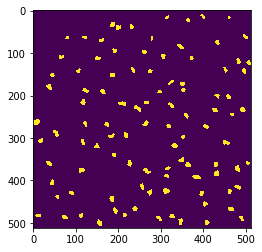

In [16]:
plt.imshow(soma_mask)

# Compute Thresholds in Local Activity filter

In [10]:
path = root_folder+'/set4/'
res = np.zeros((4,2,8))
fov = 0
for j in range(1,9):
    if j !=20:
        
        if len(str(j))==1:
            test_folder_str='00'+str(j)
        else:
            test_folder_str='0'+str(j)
        
        path_f = path+str(j)+'/'
        item = glob.glob(path_f+'*')
        print(path_f,item)
 
        sp_pp=spatial_pp(item[0])
        stack,_ = sp_pp.create_img_d4()
        ### use functions in spatia_pp for the generation of corrected stack
        ### for dataset2 and dataset3
        T,N,_ = stack.shape
        print(N)
        Res_file_path=root_folder+'/set4/dataset/FOV_'+test_folder_str+'_nf.hdf5'
        Res_mat = np.empty((N,N,2))
        dset= h5py.File(Res_file_path,'r') 
        Res_mat[:,:,0] =  np.asarray(dset['Values'])
        Res_mat[:,:,1] =  np.asarray(dset['Values_soma'])

        print(np.sum(Res_mat[:300,:300,1]))
        th_res = tune_th(stack[:,:300,:300],mask=Res_mat[:300,:300,:],BB_dim=48)
        
        thre = th_res.save_im()
        print('SOMA',thre[:,0])
        print('Proc',thre[:,1])
        if j>20:
            res[:,:,j-2] = thre
        else:
            res[:,:,j-1] = thre



/astro_folder/set4/1/ ['/astro_folder/set4/1/TSeries-06282021-1014-791_Ch1__movie_corrected.tiff']
512
3354.0
THRESH 0.3 0.15
THRESH 0.25 0.1
THRESH 0.2 0.07
THRESH 0.15 0.05
SOMA [3.60763268 1.1627907  0.47704234 0.14907573]
Proc [13.6436967   6.96012906  4.26365522  3.2265499 ]
/astro_folder/set4/2/ ['/astro_folder/set4/2/TSeries-07012021-0901-798_Ch1__movie_corrected.tiff']
512
2756.0
THRESH 0.3 0.15
THRESH 0.25 0.1
THRESH 0.2 0.07
THRESH 0.15 0.05
SOMA [0.79825835 0.07256894 0.         0.        ]
Proc [3.72409326 2.81735751 2.4611399  2.39637306]
/astro_folder/set4/3/ ['/astro_folder/set4/3/TSeries-07012021-0901-799_Ch1__movie_corrected.tiff']
512
2522.0
THRESH 0.3 0.15
THRESH 0.25 0.1
THRESH 0.2 0.07
THRESH 0.15 0.05
SOMA [6.66137986 0.15860428 0.         0.        ]
Proc [29.79885057 12.21264368 10.37356322 10.31609195]
/astro_folder/set4/4/ ['/astro_folder/set4/4/TOMATO_14_Ch1__concatenate_corrected_aligned.tiff']
512
2815.0
THRESH 0.3 0.15
THRESH 0.25 0.1
THRESH 0.2 0.07
THRES

In [9]:
# res[:,0,:3]

(4, 2)


Text(0.5, 1.0, 'Processes')

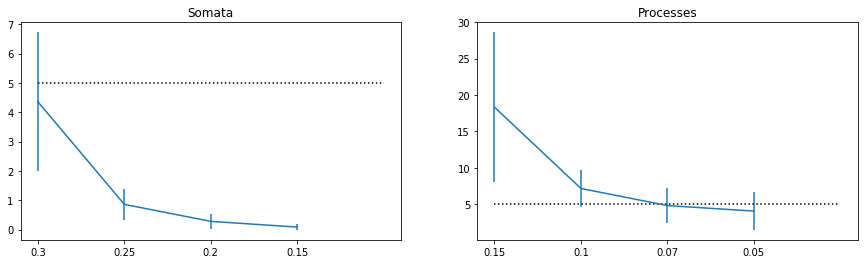

In [11]:
vec = np.mean(res,axis=2)
err = np.std(res,axis=2)
print(vec.shape)
fig,[ax1,ax2] = plt.subplots(figsize=(15,4),ncols=2,nrows=1)
ax1.errorbar(np.arange(4),vec[:,0],yerr=err[:,0])
ax2.errorbar(np.arange(4),vec[:,1],yerr=err[:,1])
ax1.set_xticks(np.arange(4))
ax2.set_xticks(np.arange(4))
ax1.set_xticklabels([0.3,0.25,0.20,0.15])
ax2.set_xticklabels([0.15,0.1,0.07,0.05])
ax1.hlines(xmin=0,xmax=4,y=5,linestyles='dotted')
ax2.hlines(xmin=0,xmax=4,y=5,linestyles='dotted')
ax1.set_title('Somata')
ax2.set_title('Processes')


In [17]:
dict_param['th1_p']=0.25
dict_param['th2_p']=0.1

# Activity Map Generator: Set percentile

In [9]:

res = np.empty((24,7))
fov = 0
resize=False

for j in range(1,26):
    if j !=20:
        
        if len(str(j))==1:
            test_folder_str='00'+str(j)
        else:
            test_folder_str='0'+str(j)
        
        path_f = path+str(j)+'/'
        item = glob.glob(path_f+'*')
        print(path_f,item)
        
        #for dataset2 and dataset3 this class is necessary to transform the stack
        #sp_pp=spatial_pp(item[0])
        #stack,_ = sp_pp.create_img()

        stack = io.imread(item[0])
        T,N,_ = stack.shape

        Res_file_path=root_path+'/set1/dataset/SMALL_'+test_folder_str+'_nf.hdf5'
        Res_mat = np.empty((N,N,2))
        dset= h5py.File(Res_file_path,'r') 
        Res_mat[:,:,0] =  np.asarray(dset['Values'])
        Res_mat[:,:,1] =  np.asarray(dset['Values_soma'])


        maskGT = np.sum(Res_mat,axis=2)
        maskGT[maskGT>1]=1
        iter_ = 0
        for i in [30,40,50,60,70,80,90]:
            
            dict_param['percentile'] = i 
            
            cr = sel_active_reg(stack,dict_param,verbose=False)
            mask = cr.get_mask()
            res[fov,iter_] = f1_score(maskGT.flatten(), mask.flatten(), average='binary')
            iter_+=1
        fov+=1

/media/DATA/jbonato/astro_segm/set1/1/ ['/media/DATA/jbonato/astro_segm/set1/1/TSeries-04082019-1513-1250_Ch2__movie_corrected_aligned.tiff']
/media/DATA/jbonato/astro_segm/set1/2/ ['/media/DATA/jbonato/astro_segm/set1/2/TSeries-04082019-1513-1251_Ch2__movie_corrected_aligned.tiff']
/media/DATA/jbonato/astro_segm/set1/3/ ['/media/DATA/jbonato/astro_segm/set1/3/TSeries-04082019-1513-1252_Ch2__movie_corrected_aligned.tiff']
/media/DATA/jbonato/astro_segm/set1/4/ ['/media/DATA/jbonato/astro_segm/set1/4/TSeries-04112019-1605-1257_Ch2__movie_corrected_aligned.tiff']
/media/DATA/jbonato/astro_segm/set1/5/ ['/media/DATA/jbonato/astro_segm/set1/5/TSeries-04112019-1605-1258_Ch2__movie_corrected_aligned.tiff']
/media/DATA/jbonato/astro_segm/set1/6/ ['/media/DATA/jbonato/astro_segm/set1/6/TSeries-04112019-1605-1266_Ch2__movie_corrected_aligned.tiff']
/media/DATA/jbonato/astro_segm/set1/7/ ['/media/DATA/jbonato/astro_segm/set1/7/TSeries-04112019-1605-1267_Ch2__movie_corrected_aligned.tiff']
/media

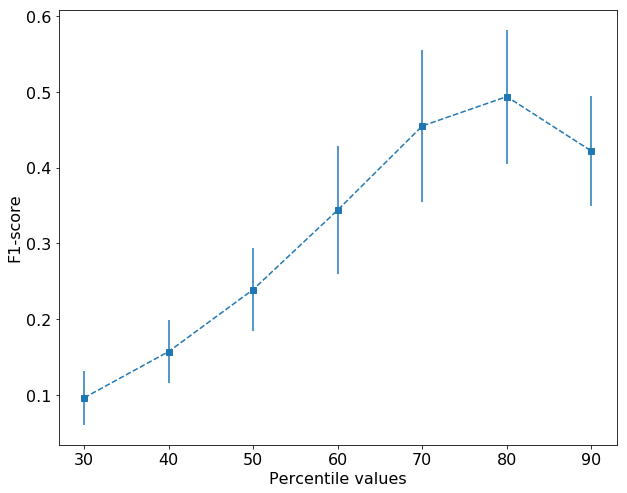

In [10]:
fig, ax = plt.subplots(figsize=(10,8),ncols = 1, nrows = 1)

ax.errorbar(np.arange(7),np.nanmean(res,axis=0),yerr=np.nanstd(res,axis=0),fmt='--', marker='s')
ax.set_xticklabels(labels =[0,30,40,50,60,70,80,90],fontsize=16)

ax.set_xlabel('Percentile values',fontsize=16)
ax.set_ylabel('F1-score',fontsize=16)
ax.tick_params(axis="y", labelsize=16)


In [18]:
dict_param['percentile']=80

# Save Dictionary values

In [21]:
set_dir=root_folder+'/set4/.tmp/'

if not(os.path.exists(set_dir)):
    os.mkdir(set_dir)
    print('Created',set_dir)
    
with open(set_dir+'dict_dataset.txt', "wb") as fp:   #Pickling
    pickle.dump(dict_param, fp)

In [22]:
dict_param

{'list': [0,
  29,
  58,
  87,
  116,
  145,
  174,
  203,
  232,
  261,
  290,
  319,
  348,
  377,
  406,
  435,
  464],
 'blocks': 34,
 'threads': 24,
 'BPM_ratio': 2,
 'bb': 48,
 'N_pix_st': 50,
 'astr_min': 30,
 'percentile': 80,
 'pad': 0,
 'astro_num': 90,
 'init_th': 0.5,
 'decr_dim': 5,
 'decr_th': 12,
 'corr_int': True,
 'gpu_flag': True,
 'max_min': array([258,  40]),
 'th1_p': 0.25,
 'th2_p': 0.1}